In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Часть 1. Предобработка
Предобработка такая же что и в первом дз

In [3]:
data = pd.read_csv('./Shanghai_HMT_2010.csv')
data.head()

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,-6.0,59.48,1026.1,1.0,cv,1.0,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,-6.0,59.48,1025.1,1.0,SE,2.0,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,-7.0,59.21,1025.1,0.0,SE,4.0,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,-6.0,63.94,1024.0,0.0,SE,5.0,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,-6.0,63.94,1023.0,0.0,SE,8.0,0.0,0.0


In [4]:
null_value_stats = data.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

PM_Jingan        27884
PM_US Post       18545
PM_Xuhui         27395
DEWP                13
HUMI                13
PRES                28
TEMP                13
cbwd                12
Iws                 12
precipitation     4009
Iprec             4009
dtype: int64

Выбрасываем наны и колокну с номерами

In [5]:
work_data = data.drop(data[data["PRES"].isnull()].index)
work_data = work_data.drop(['No'], axis=1)
work_data = work_data.dropna()

In [6]:
date = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
work_data = work_data.join(pd.DataFrame({'date' : date} ) )
#work_data['date'] = work_data['date'].astype('int').astype('float'); 
work_data.head()

,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,date
26304,2013,1,1,0,4,66.0,70.0,71.0,-5.0,69.00,1023.0,0.0,SW,60.0,0.0,0.0,2013-01-01 00:00:00
26305,2013,1,1,1,4,67.0,76.0,72.0,-5.0,69.00,1023.0,0.0,SW,62.0,0.0,0.0,2013-01-01 01:00:00
26307,2013,1,1,3,4,73.0,78.0,74.0,-4.0,74.41,1023.0,0.0,SW,65.0,0.0,0.0,2013-01-01 03:00:00
26308,2013,1,1,4,4,75.0,77.0,77.0,-4.0,80.04,1023.0,-1.0,SW,68.0,0.0,0.0,2013-01-01 04:00:00
26309,2013,1,1,5,4,73.0,78.0,80.0,-4.0,80.04,1023.0,-1.0,SW,70.0,0.0,0.0,2013-01-01 05:00:00


In [7]:
print(work_data.drop(["PRES"], axis=1).dtypes)
cat_f_ind = np.where(work_data.drop(["PRES"], axis=1).dtypes != float)[0]

year                      int64
month                     int64
day                       int64
hour                      int64
season                    int64
PM_Jingan               float64
PM_US Post              float64
PM_Xuhui                float64
DEWP                    float64
HUMI                    float64
TEMP                    float64
cbwd                     object
Iws                     float64
precipitation           float64
Iprec                   float64
date             datetime64[ns]
dtype: object


# Часть 2. Предсказание по модели Уинтерса

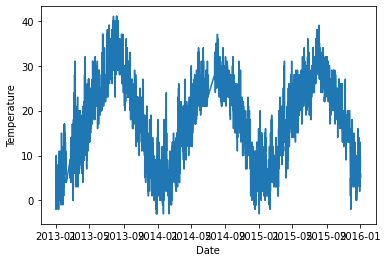

In [8]:
date = work_data["date"].to_numpy()
temp = work_data["TEMP"].to_numpy()

plt.plot(date, temp)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

### Наблюдения :


*   Есть сезонность
*   Есть спадающий тренд 

Для этого будем использовать библиотечную функцию, что разложит ряд по мультипликативной модели и по линейно модели (тут разница просто в том что тренд либо тривиально умножается на сезонность, либо складывается с ней)

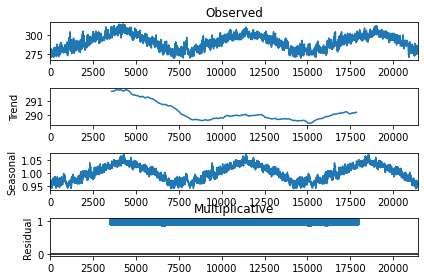

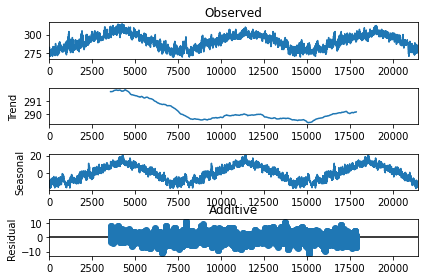

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(temp+273, period=len(temp)//3, model='multiplicative')
decompose_result.plot()
plt.title('Multiplicative')
plt.show()

decompose_result = seasonal_decompose(temp+273, period=len(temp)//3, model='additive')
decompose_result.plot()
plt.title('Additive')
plt.show()

Короче, мультипликативная модель дает невязку поменьше, а наблюдаемый тренд более всего похож на экспонециальный (такой и возьмем в модели Уинтерса)

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_set = temp[:2*len(temp)//3]
test_set = temp[2*len(temp)//3:-1]

model = ExponentialSmoothing(temp,trend='add',seasonal='add',seasonal_periods=2, damped_trend=True)
model = model.fit()
predictions = model.predict(start=2*len(temp)//3+1, end=len(temp)-1)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


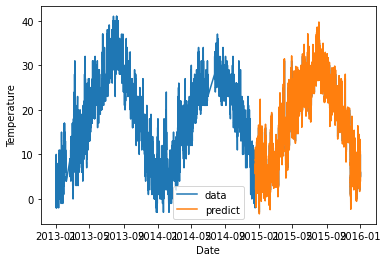

In [11]:
plt.plot(date, temp, label='data')
plt.plot(date[2*len(temp)//3:-1], predictions, label='predict')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error

print('MSE :', mean_squared_error(temp[2*len(temp)//3:-1], predictions))

MSE : 0.22274353639341885


# Часть 2. Адаптивная композиция моделей

In [22]:
from statsmodels.tsa.ar_model import AutoReg

model_1 = ExponentialSmoothing(temp,trend='add',seasonal='add',seasonal_periods=2, damped_trend=True)
model_1 = model_1.fit()
predictions_1 = model_1.predict(start=2*len(temp)//3+1, end=len(temp)-1)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [16]:
model_2 = AutoReg(temp,lags=10,trend = 'c', seasonal = True, period=len(temp)//3)
model_2 = model_2.fit()
predictions_2 = model_2.predict(start=2*len(temp)//3+1, end=len(temp)-1)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


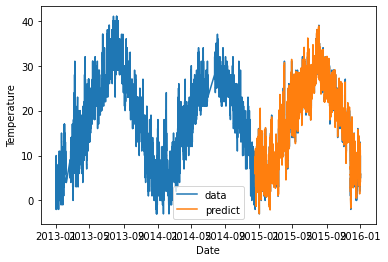

In [24]:
plt.plot(date, temp, label='data')
plt.plot(date[2*len(temp)//3:-1], predictions_2, label='predict')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [25]:
gamma = 0.5

err1 = temp[2*len(temp)//3:-1] - predictions_1
err2 = temp[2*len(temp)//3:-1] - predictions_2
for i in range(1, len(err1)):
  err1[i] = gamma * abs(err1[i]) + (1-gamma) * err1[i-1]
  err2[i] = gamma * abs(err2[i]) + (1-gamma) * err2[i-1]

predictions = 1 / (1/err1+1/err2) * (1/err1 * predictions_1 + 1/err2 * predictions_2)

In [27]:
print('MSE model 1:', mean_squared_error(temp[2*len(temp)//3:-1], predictions_1))
print('MSE model 2:', mean_squared_error(temp[2*len(temp)//3:-1], predictions_2))
print('MSE combination of models:', mean_squared_error(temp[2*len(temp)//3:-1], predictions))

MSE model 1: 0.22274353639341885
MSE model 2: 0.5092608696770722
MSE combination of models: 0.19951465249854805
